# 测试部分

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
#font_manager.fontManager.addfont("/home/yltang/.local/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/Times New Roman.ttf")

In [2]:
plt.style.use('classic')
font1 = {'family': 'Times New Roman',
         'weight': 'normal',
         'size': 15,
         }

In [3]:
#加载数据
train_data_file = np.load(f'/data/yltang/simulated_data_1/data_new/concated_data/final_data/SNIa.npz')
train_data = train_data_file["data"]
train_label = train_data_file["label"]

In [4]:
train_data.shape

(1800, 40, 6)

In [5]:
num=100
num_band = 3
color = ['r','g','b','k','y','m']
fmt = ['.r','.g','.b','.k','.y','.m']
labels = ['u','g','r','i','z','y']
sampling_intervals=1

101


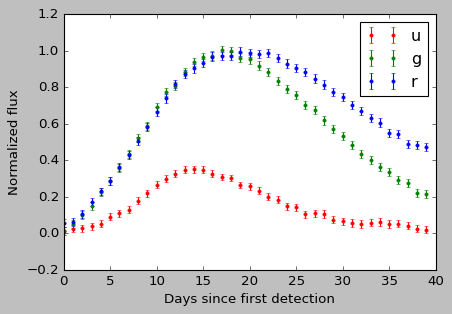

In [6]:
import matplotlib.pyplot as plt
num = num + 1
plt.figure(figsize=(6,4))
for i in range(3):
    mjd = np.linspace(0,int(40/sampling_intervals)-1,int(40/sampling_intervals))
    observed_flux = train_data[num,:,i]
    observed_flux_err = train_data[num,:,i+num_band]
    
    plt.errorbar(x=mjd, y=observed_flux, yerr=observed_flux_err, fmt=fmt[i], capsize=2,label=labels[i])
    plt.legend()

    plt.xlabel("Days since first detection")
    plt.ylabel("Normalized flux")
print(num)

In [7]:
sample_index = num

In [8]:
train_data[sample_index].shape

(40, 6)

## 下采样

In [13]:
#第一次随机下采样
time_to_observed = 40
observable_data = int(time_to_observed*0.1)

# 定义范围
lower_bound = 0
upper_bound = time_to_observed
num_unique_numbers_needed = observable_data

# 创建指定范围内的所有整数列表
all_numbers = np.arange(lower_bound, upper_bound)

# 使用choice函数从中随机选择不重复的数字
unique_random_numbers = np.random.choice(all_numbers, num_unique_numbers_needed, replace=False)
observed_index = np.sort(unique_random_numbers)

# 输出结果
print(len(observed_index),observed_index)

4 [21 26 38 39]


In [10]:
observed_index = np.append(observed_index,89)
observable_data = len(observed_index)
print(len(observed_index),observed_index)

5 [ 7  9 14 30 89]


In [11]:
observed_index = np.array([ 0,  0,  1,  1,  2,  2,  3,  4,  4,  5,  5,  9, 10, 11, 12, 13, 14,
       14, 16, 16, 17, 17, 19, 19, 21, 25, 26, 27, 29, 33, 39])
observed_index = np.unique(observed_index)
observed_index

array([ 0,  1,  2,  3,  4,  5,  9, 10, 11, 12, 13, 14, 16, 17, 19, 21, 25,
       26, 27, 29, 33, 39])

In [14]:
observed_index = observed_index[:]
observable_data = int(len(observed_index))

In [15]:
mjd_original = np.linspace(0,int(40/sampling_intervals)-1,int(40/sampling_intervals))
mjd = np.zeros(shape=(3,observable_data))
flux = np.zeros(shape=(3,observable_data))
flux_err = np.zeros(shape=(3,observable_data))
for  j, observed_index_ in enumerate(observed_index):
    for i in range(3):
        mjd[i,j] = mjd_original[observed_index_]
        flux[i,j] = train_data[num, observed_index_,i]
        flux_err[i,j] = train_data[num, observed_index_, i+num_band]

In [16]:
len(mjd[0]), len(flux[0])

(4, 4)

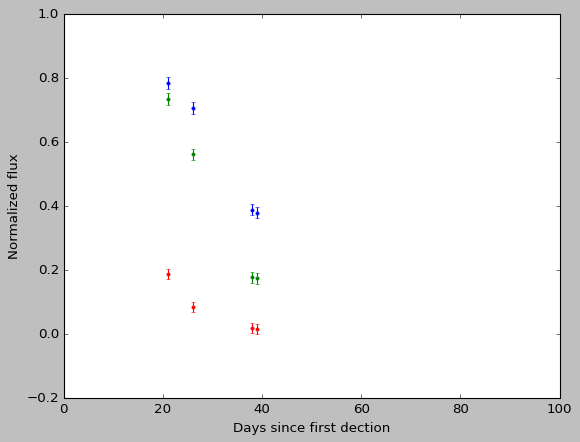

In [17]:
import matplotlib.pyplot as plt
fmt = ['.r','.g','.b','.k','.y','.m']
plt.figure(figsize=(8,6))
for i in range(3):
    plt.errorbar(x=mjd[i], y=flux[i]*0.8, yerr=flux_err[i]*0.8, fmt=fmt[i], capsize=2)
    plt.xlim(0,100)
    plt.xlabel("Days since first dection")
    plt.ylabel("Normalized flux")

In [18]:
#central_wave_length = [3570.0,4767.0,6215.0,7545.0,8708.0,10040.0]
central_wave_length = [3570.0,4767.0,6215.0]
central_wave_length = np.array(central_wave_length)

In [19]:
mjd_stack = np.hstack([mjd[0],mjd[1],mjd[2]])
flux_stack = np.hstack([flux[0],flux[1],flux[2]])
flux_err_stack = np.hstack([flux_err[0],flux_err[1],flux_err[2]])
wavelength_stack = np.hstack([np.ones(shape=mjd[0].shape)*central_wave_length[0],
                              np.ones(shape=mjd[1].shape)*central_wave_length[1],
                             np.ones(shape=mjd[2].shape)*central_wave_length[2]])

In [20]:
gind = np.argsort(mjd_stack)
time = mjd_stack[gind]
fluxes = flux_stack[gind]
flux_errs = flux_err_stack[gind]
filters = wavelength_stack[gind]

Text(0, 0.5, 'flux')

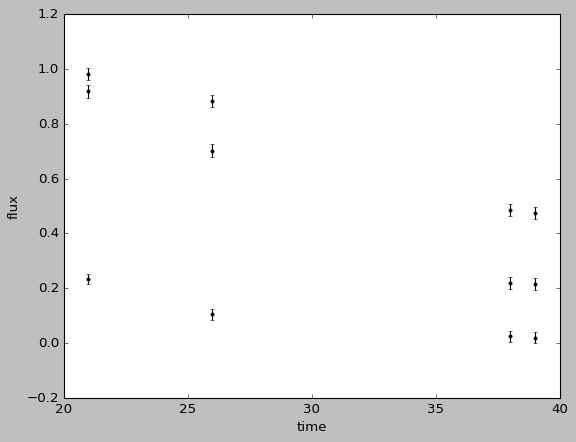

In [21]:
plt.errorbar(x=time, y=fluxes, yerr=flux_errs, fmt=".k", capsize=2)
plt.xlabel("time")
plt.ylabel("flux")

In [22]:
import george

In [23]:
signal_to_noises = np.abs(fluxes) / np.sqrt(
            flux_errs ** 2 + (1e-2 * np.max(fluxes)) ** 2
        )
index = np.argmax(signal_to_noises)
scale = np.abs(fluxes[index])
scale

0.981306498228485

In [24]:
index = np.argmax(fluxes)
scale = np.abs(fluxes[index])
scale

0.981306498228485

In [25]:
from george import kernels
guess_length_scale=20.0
kernel = (0.5 * scale) ** 2 * kernels.Matern32Kernel(
            [guess_length_scale ** 2, 6000 ** 2], ndim=2
        )
kernel

ConstantKernel(log_constant=-2.117182409141013, ndim=2, axes=array([0, 1])) * Matern32Kernel(metric=Metric(array([4.0e+02, 3.6e+07]), ndim=2, axes=array([0, 1]), bounds=[(None, None), (None, None)]), block=None)

In [26]:
x_ = np.vstack([time, filters]).T
x_.shape

(12, 2)

In [27]:
gp = george.GP(kernel)
gp.compute(x_, flux_errs)

In [28]:
x_pred = np.linspace(min(time), max(time), 500)
x_pred = np.vstack([x_pred,np.ones(x_pred.shape)*central_wave_length[0]])

In [29]:
pred, pred_var = gp.predict(fluxes, x_pred.T, return_var=True)

In [30]:
x_pred_ = x_pred[0,:]
x_pred_.shape

(500,)

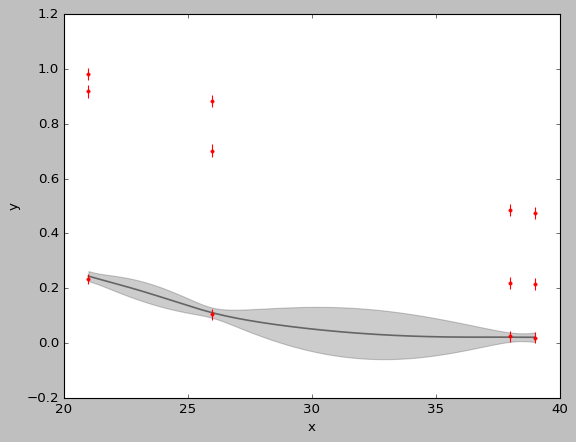

In [31]:
plt.fill_between(x_pred_, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
plt.plot(x_pred_, pred, "k", lw=1.5, alpha=0.5)
plt.errorbar(time, fluxes, yerr=flux_errs, fmt=".r", capsize=0)


plt.xlabel("x")
plt.ylabel("y");

In [32]:
print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(fluxes)))

Initial ln-likelihood: 0.04


In [33]:
from scipy.optimize import minimize

def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(fluxes)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(fluxes)

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(fluxes)))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -8.93104063852989
        x: [-1.442e+00  7.863e+00  1.621e+01]
      nit: 12
      jac: [ 2.884e-07 -8.422e-07 -1.048e-07]
 hess_inv: [[ 1.027e+00  9.282e-01  6.789e-01]
            [ 9.282e-01  1.140e+00  5.701e-01]
            [ 6.789e-01  5.701e-01  9.990e-01]]
     nfev: 14
     njev: 14

Final ln-likelihood: 8.93


In [34]:
color = ['r','g','b','k','y','m']

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

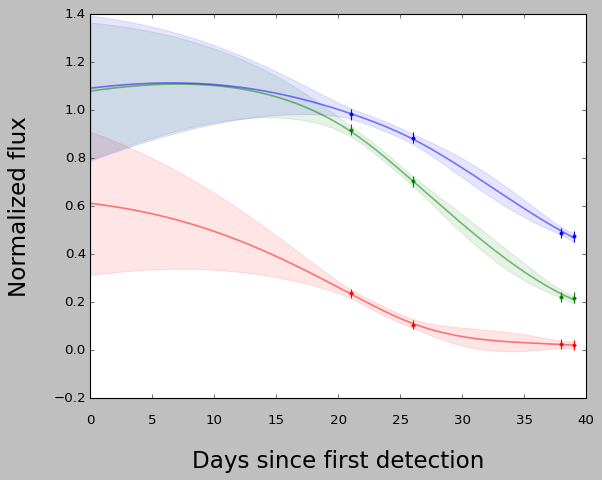

In [35]:
plt.figure(figsize=(8,6))
for band in range(3):
    x_pred = np.linspace(0, max(time), 300)
    #print(x_pred)
    x_pred = np.vstack([x_pred,np.ones(x_pred.shape)*central_wave_length[band]])
    pred, pred_var = gp.predict(fluxes, x_pred.T, return_var=True)
    x_pred_ = x_pred[0,:]
    plt.fill_between(x_pred_, pred -  np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color=color[band], alpha=0.1)
    plt.plot(x_pred_, pred, color[band], lw=1.5, alpha=0.5)
    plt.errorbar(mjd[band], flux[band], yerr= flux_err[band], fmt=fmt[band], capsize=0)
    plt.errorbar(x=mjd, y=observed_flux, yerr=observed_flux_err, fmt=fmt[i], capsize=2,label=labels[i])

    plt.xlabel("Days since first detection",fontsize="xx-large", labelpad=20,fontproperties="Times New Roman")
    plt.ylabel("Normalized flux",fontsize="xx-large", labelpad=20,fontproperties="Times New Roman")

    plt.xticks(fontsize="xx-large",position=(0, -0.03),fontproperties="Times New Roman")
    plt.yticks(fontsize="xx-large",fontproperties="Times New Roman")

In [36]:
label = ["u","g","r"]
delta_redshit = 0.05
delta_lambda = central_wave_length * delta_redshit
delta_lambda

array([178.5 , 238.35, 310.75])

In [37]:
mjd.shape, flux.shape

((3, 4), (3, 4))

In [34]:
# 1. 相关模块导入
import numpy as np
import matplotlib.pyplot as plt
#plt.rcParams['font.sans-serif'] = ['SimHei'] # 正常显示中文字体
#plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

# 3. 绘图
  # 3.1 共享y轴
figure,(ax1,ax2,ax3) = plt.subplots(1,3,
                                    figsize=(6*3,5),
                                    dpi=1000,
                                    # 共享y轴
                                    sharey=True)

# 2. 创建制图数据
ax_list = [ax1,ax2,ax3]
for i in range(3):
    x_pred = np.linspace(0, max(time), 300)
    #print(x_pred)
    x_pred = np.vstack([x_pred,np.ones(x_pred.shape)*central_wave_length[i]])
    pred, pred_var = gp.predict(fluxes, x_pred.T, return_var=True)
    x_pred_ = x_pred[0,:]

    x_pred = np.linspace(0, max(time), 300)
    x_pred_plus = np.vstack([x_pred,np.ones(x_pred.shape)*(central_wave_length[i]+delta_lambda[i])])
    pred_plus, pred_var_plus = gp.predict(fluxes, x_pred_plus.T, return_var=True)
    x_pred_plus_ = x_pred_plus[0,:]

    x_pred = np.linspace(0, max(time), 300)
    x_pred_mines = np.vstack([x_pred,np.ones(x_pred.shape)*(central_wave_length[i]-delta_lambda[i])])
    pred_mines, pred_var_mines = gp.predict(fluxes, x_pred_mines.T, return_var=True)
    x_pred_mines_ = x_pred_mines[0,:]
    
    ax_list[i].fill_between(x_pred_-min(x_pred_), pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
               color=color[i], alpha=0.5)
    ax_list[i].plot(x_pred_-min(x_pred_), pred, color[i], lw=1.0, alpha=1.0, label="Original Fit")
    #plt.xlim(10,120)
    ax_list[i].errorbar(mjd[i], flux[i], yerr=flux_err[i], fmt=fmt[i], capsize=0)
    #ax_list[j].errorbar(x=mjd_1, y=flux_list[j], yerr=flux_err_list[j],color=color[i], marker=markers[i], capsize=2,label=label[i])

    #redshift up
    ax_list[i].fill_between(x_pred_plus_-min(x_pred_plus_), pred_plus - np.sqrt(pred_var_plus/2), pred_plus + np.sqrt(pred_var_plus/2),
               color=color[i], alpha=0.1)
    ax_list[i].plot(x_pred_plus_-min(x_pred_plus_), pred_plus, color[i], linestyle='dashed',lw=1.0, alpha=1.0, label="Higher Redshif")


    #redshift down
    ax_list[i].fill_between(x_pred_mines_-min(x_pred_mines_), pred_mines - np.sqrt(pred_var_mines/2), pred_mines + np.sqrt(pred_var_mines/2),
               color=color[i], alpha=0.1)
    ax_list[i].plot(x_pred_mines_-min(x_pred_mines_), pred_mines, color[i], linestyle=':',lw=1.0, alpha=1.0, label="Lower Redshift")
    
    if i==0:
        ax_list[i].set_ylabel("Normalized Flux",fontsize="x-large", labelpad=20,fontproperties="Times New Roman")
    elif i==1:
        ax_list[i].set_xlabel("Times",fontsize="x-large",labelpad=30,fontproperties="Times New Roman")
        
    ax_list[i].legend(fontsize="x-large",
                      #bbox_to_anchor=(0,0.34,1.028, 1),
                      loc="upper right",
                      framealpha=0.2,
                      prop=font1
                     )
    #设置坐标轴字体
    x1_label = ax_list[i].get_xticklabels() 
    [x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
    y1_label = ax_list[i].get_yticklabels() 
    [y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]

    #ax_list[j].set_ylim(-0.3,1.2)
        
    # 2.4 坐标轴刻度字体颜色设置
    ax_list[i].tick_params(axis='y',
                     labelsize=15, # y轴字体大小设置
                     #color='r',    # y轴标签颜色设置  
                     #labelcolor='b', # y轴字体颜色设置
                     direction='in' # y轴标签方向设置
                      ) 
    
    ax_list[i].tick_params(axis='x',
                     labelsize=15, # y轴字体大小设置
                     #color='r',    # y轴标签颜色设置  
                     #labelcolor='b', # y轴字体颜色设置
                     direction='in' # y轴标签方向设置
                      ) 

# 调整子图形之间的纵向距离
figure.subplots_adjust(wspace=0.07) 
plt.savefig("Augmentation.jpg",bbox_inches='tight')

plt.show()